In [1]:
import numpy as np
import matplotlib.pyplot as plt
import butcher
import bro
import os

from numpy import savetxt
from astropy.io import ascii
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle

In [2]:
#Reading in the data

#Get the data directory
cwd = os.getcwd()
data_dir = cwd.replace('Figure_2', 'Data\\')

#ASAS data
orgasas_data = ascii.read(data_dir + 'asas.csv')
asas_mask = (orgasas_data['emag'] < 0.05)
asas_data = orgasas_data[asas_mask]

asas_flux = butcher.mag_to_flux(asas_data['mag'])
asas_eflux = butcher.emag_to_eflux(asas_data['mag'], asas_data['emag'])

#ASASSN data
orgasassn_data = ascii.read(data_dir + 'asassn.csv')
asassn_mask = (orgasassn_data['emag'] < 0.05)
asassn_data = orgasassn_data[asassn_mask]

asassn_flux = butcher.mag_to_flux(asassn_data['mag'])
asassn_eflux = butcher.emag_to_eflux(asassn_data['mag'], asassn_data['emag'])

#KELT data
orgkelt_data = ascii.read(data_dir + 'kelt.csv')
kelt_mask = (orgkelt_data['emag'] < 0.05)
kelt_data = orgkelt_data[kelt_mask]

kelt_flux = butcher.mag_to_flux(kelt_data['mag'])
kelt_eflux = butcher.emag_to_eflux(kelt_data['mag'], kelt_data['emag'])

#PROMPT data
orgprompt_data = ascii.read(data_dir + 'prompt.csv') #time is JD-2450000
prompt_mask = (orgprompt_data['emag'] < 0.05)
prompt_data = orgprompt_data[prompt_mask]

prompt_flux = butcher.mag_to_flux(prompt_data['mag'])
prompt_eflux = butcher.emag_to_eflux(prompt_data['mag'], prompt_data['emag'])

#ROAD data
orgroad_data = ascii.read(data_dir + 'road.csv') #time is JD-2450000
road_mask = (orgroad_data['emag'] < 0.05)
road_data = orgroad_data[road_mask]

road_flux = butcher.mag_to_flux(road_data['mag'])
road_eflux = butcher.emag_to_eflux(road_data['mag'], road_data['emag'])

In [3]:
#Correct for the long term flux decrease mentioned in section 3.1

asas_flux = butcher.long_correct(asas_data['MJD'], asas_flux, asas_eflux)
asassn_flux = butcher.long_correct(asassn_data['MJD'], asassn_flux, asassn_eflux)
kelt_flux = butcher.long_correct(kelt_data['HJD'], kelt_flux, kelt_eflux)
prompt_flux = butcher.long_correct(prompt_data['HJD'], prompt_flux, prompt_eflux)
road_flux = butcher.long_correct(road_data['HJD'], road_flux, road_eflux)

In [4]:
#Store the individual telescopes in lists

times = [asas_data['MJD'], asassn_data['MJD'], kelt_data['HJD'], prompt_data['HJD'], road_data['HJD']]
fluxes = [asas_flux, asassn_flux, kelt_flux, prompt_flux, road_flux]
uncertainties = [asas_eflux, asassn_eflux, kelt_eflux, prompt_eflux, road_eflux]
names = ['ASAS', 'ASAS-SN', 'KELT', 'PROMPT', 'ROAD']

In [6]:
#Remove the periodic signals

names = ['ASAS', 'ASASSN', 'KELT', 'PROMPT', 'ROAD']
corr_fluxes = []
for j in range(5):
    time, flux, eflux = times[j], fluxes[j], uncertainties[j]

    corrflux1, periods1, freq1, power1 = bro.short_correct(time, flux, eflux, min_chunk_size = 10)
    
    #Correct the bro corrected Lombscargle
    corrflux2, periods2, freq2, power2 = bro.short_correct(time, corrflux1, eflux, min_chunk_size = 10)
    frequencies = 1/np.linspace(2, 10, 3000)
    final_power = LombScargle(time, corrflux2-np.mean(corrflux2), dy = eflux).power(frequencies)
    max_period = 1/frequencies[list(final_power).index(np.max(final_power))]
    
    corr_fluxes.append(corrflux2)

C:\Users\MasterofAlorgia\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:729: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma


In [8]:
#Removing outliers

len_before = 0
for i in range(5):
    len_before += len(times[i])
    corr_flux = corr_fluxes[i]
    low, high = np.percentile(corr_flux,[5, 95])
    mask = (corr_flux < high)*(corr_flux > low)
    
    times[i], corr_fluxes[i], uncertainties[i] = times[i][mask], corr_flux[mask], uncertainties[i][mask]
    
len_after = 0
for i in range(5):
    len_after += len(times[i])
print("We removed: ", '{0:.2f}'.format((len_before-len_after)*100/len_before), ' % of the data')

We removed:  10.04  % of the data


In [9]:
#Sticking the different sets together
all_times =  np.concatenate((np.array(times[0]), np.array(times[1]), np.array(times[2]), np.array(times[3]), np.array(times[4])))
all_corflux = np.concatenate( (np.array(corr_fluxes[0]+1), np.array(corr_fluxes[1]+1), np.array(corr_fluxes[2]+1), np.array(corr_fluxes[3]+1),  np.array(corr_fluxes[4]+1)))
all_eflux =  np.concatenate((np.array(uncertainties[0]), np.array(uncertainties[1]), np.array(uncertainties[2]), np.array(uncertainties[3]), np.array(uncertainties[4])))
all_times_final, all_corflux_final, all_eflux_final = zip(*sorted(zip(all_times, all_corflux, all_eflux))) #Sorting the data timewise

karpa = np.zeros((len(all_times_final), 3))
karpa[:, 0] = all_times_final
karpa[:, 1] = all_corflux_final
karpa[:, 2] = all_eflux_final

karpa[: , 1] /= np.mean(karpa[:, 1]) #Make sure the mean is equal to 1

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


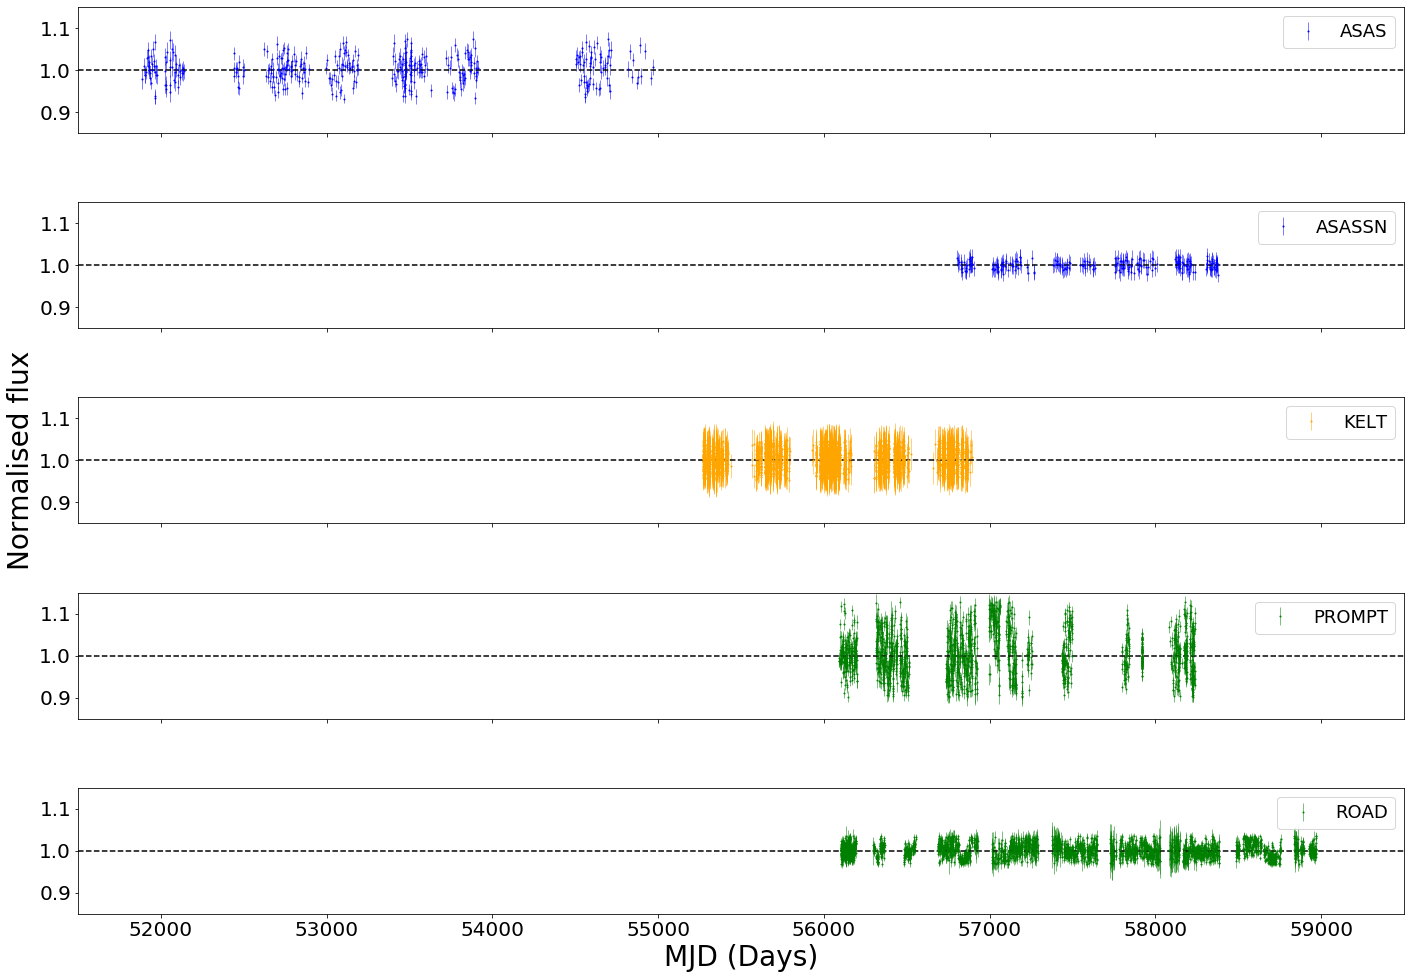

In [11]:
#Creating the figure

import matplotlib
plt.style.use('seaborn-dark-palette')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)
colours = ['blue', 'blue', 'orange', 'green', 'green']

fig, ax = plt.subplots(5)
for i in range(5):
    ax[i].errorbar(times[i], corr_fluxes[i]+1, uncertainties[i], fmt='.', ms=2, elinewidth = 0.5, label = names[i], color=colours[i])
    ax[i].legend(fontsize = 18)
    ax[i].axhline(y = 1.0, linestyle = '--', c='black')
    ax[i].set_xlim(51500, 59500)
    ax[i].set_ylim(0.85, 1.15)
    if i != 4:
        plt.setp(ax[i].get_xticklabels(), visible=False)
    
ax[2].set_ylabel('Normalised flux', fontsize=28)
ax[4].set_xlabel('MJD (Days)', fontsize=28)
fig = plt.gcf()
fig.set_size_inches(20,14)
plt.tight_layout()
#plt.savefig('KARPA_lightcurve.pdf')
plt.show()

In [ ]:
#np.savetxt("Final_Combined_Data.csv", karpa, header = 'Time,Flux,Eflux') 